In [28]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [4]:
a=pd.read_csv(os.path.join(os.environ["HOME"],'Downloads','my_sacct.txt'),
              delim_whitespace=True,header=None,
              names=['slurm_id','status','num_nodes','time'])



In [5]:
for i,name in zip([0,1,2],['multi_hr','min','sec']):
    a[name]= a['time'].str.split(':').str[i]

In [6]:
a['multi_hr'].str.split('-').str.len().value_counts()

1    295
2      1
Name: multi_hr, dtype: int64

In [8]:
hasExtra24= a['multi_hr'].str.split('-').str.len() > 1
a.loc[hasExtra24,'multi_hr'], a.loc[~hasExtra24,'multi_hr'].iloc[0]

(196    1-00
 Name: multi_hr, dtype: object, '00')

In [15]:
a['extra_hrs']= np.zeros(a.shape[0])
a.loc[hasExtra24,'extra_hrs']= 24*a.loc[hasExtra24,'multi_hr'].str.split('-').str[0].astype(float)
a['extra_hrs'].value_counts()

0.0     295
24.0      1
Name: extra_hrs, dtype: int64

In [16]:
a['hrs']= np.zeros(a.shape[0])
# No 01-05, just 05
a.loc[~hasExtra24,'hrs']= a.loc[~hasExtra24,'multi_hr'].astype(float)
# When 01-05, just take 05
a.loc[hasExtra24,'hrs']= a.loc[hasExtra24,'multi_hr'].str.split('-').str[1].astype(float)
a.loc[:,'hrs'] +=  a['extra_hrs']

In [18]:
a.loc[hasExtra24,'hrs'], a.loc[~hasExtra24,'hrs'].max()

(196    24.0
 Name: hrs, dtype: float64, 18.0)

In [21]:
for col in ['min','sec']:
    a.loc[:,col]= a.loc[:,col].astype(float)

In [37]:
def cpu_hrs(nodes,h,m,s, mpp=False,cori=True):
    """
    Args:
        nodes: number of nodes
        h,m,s: hours,min,sec
    """
    cores_per_node=32
    if not cori:
        cores_per_node=24
    mpp_factor= 1.
    if mpp:
        mpp_factor= 2.5
    
    return mpp_factor * cores_per_node * nodes * h + m/60. + s/3600.

a['cpu_hrs']= cpu_hrs(a['num_nodes'],a['hrs'],a['min'],a['sec'])
print('total cpu hours (M):',a['cpu_hrs'].sum()/1e6)
print('total MPP hours (M):',a['cpu_hrs'].sum()/1e6*2.5)

total cpu hours (M): 0.259007426667
total MPP hours (M): 0.647518566667


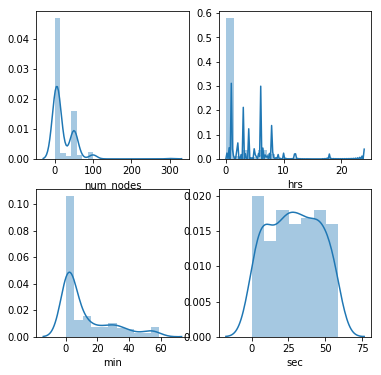

In [38]:
fig,ax= plt.subplots(2,2,figsize=(6,6))
names=['num_nodes','hrs','min','sec']
i=0
for row in range(2):
    for col in range(2):
        sns.distplot(a[names[i]],ax=ax[row,col])
        i+=1